# クラスタリング: 特徴量選択の調整とクラスタ解釈まで

## データ準備

### 使用する変数の調査

In [1]:
%matplotlib inline
import os, pathlib, pickle, math, itertools, copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.stats import percentileofscore
import matplotlib as mpl
from sklearn import mixture

In [35]:
df = pd.read_csv("../data/interim/20190605_CAN/103.486_CAR1V21_HDD2/Job1"
                  + "/SUZUKI_YSB-021_MRR_2016-04-20_06-27_0001.BLF.csv",
                names=['vin', 'time1', 'time2', 'feature', 'value'])

In [36]:
df.head()

,vin,time1,time2,feature,value
0,21,201604200627,0.295909,0FA53,0.0
1,21,201604200627,0.295909,0FA57,4.0
2,21,201604200627,0.295909,0FA43,0.0
3,21,201604200627,0.295909,0FA44,0.0
4,21,201604200627,0.295909,0FA45,0.0


#### 変化しない変数を除去

In [43]:
# 変数ごとにvalueの値の種類を数える。seriesが返る
s_nunique = df.groupby("feature")["value"].nunique() 

In [41]:
# 値の種類が1より大きいもののみを抜き出し、index(変数名)を取り出し、リスト化する
feature_multivalue = s_nunique[s_nunique > 1].index.to_list()
feature_multivalue[:5] # 先頭5個をみてみる

['0FA37', '0FA57', '11451', '11467', '11913']

In [42]:
len(feature_multivalue) # 変化する変数(残った変数)の数

104

#### 偏自己相関関数で、周期性の強い変数を除去

In [45]:
from statsmodels.tsa.stattools import pacf # 偏自己相関を計算するモジュール

In [71]:
%%time
dict_pacf = {} # lag 0 ~ 40の偏自己相関を入れる辞書
for feature in feature_multivalue:  # 値が変化する変数について調査
    s_tmp = df.loc[df.feature == feature, "value"].dropna() # seriesとして抜き出す。dropnaでnullを除去。
    acf = pacf(s_tmp, method="ols") # 偏自己相関を計算。olsは、以前エクセルで計算した方法と同様の計算方法。
    dict_pacf[feature] = acf # 変数名をkeyとする辞書に格納

CPU times: user 8min 3s, sys: 58.4 s, total: 9min 2s
Wall time: 2min 41s


In [73]:
df_pacf = pd.DataFrame(dict_pacf) # 操作しやすいようにdataframeに
df_pacf.head()

,0FA37,0FA57,11451,11467,11913,11915,11927,11947,11F47,11F53,...,3D064,3D151,3D157,3D177,3D604,3D667,3E206,3E801,46003,50007
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00
1,-0.199989,-0.199989,-0.200000,-0.200000,0.322525,-0.199992,0.999989,0.999989,-0.199989,-0.199989,...,9.994916e-01,0.999607,9.994869e-01,1.000003,0.972901,9.994269e-01,0.866659,1.000070,1.001895,1.000000e+00
2,-0.666667,-0.666667,-0.666659,-0.666659,0.219801,-0.666674,-0.991353,-0.991353,-0.666667,-0.666667,...,-1.524331e-14,-0.279910,-3.005929e-14,0.319825,-0.013736,7.924217e-14,-0.071318,0.371623,0.011516,4.998928e-01
3,-1.000000,-1.000000,-1.000000,-1.000000,0.176114,-1.000000,-0.515369,-0.515369,-1.000000,-1.000000,...,-7.516319e-15,-0.389206,3.069767e-14,0.276346,-0.013928,-1.498801e-14,-0.076810,0.200750,0.011714,1.000000e+00
4,0.975000,0.998276,1.033092,0.996948,0.618130,-0.445251,-0.093488,-0.093488,0.975000,0.999027,...,3.603543e-16,-0.346041,-8.493206e-15,-0.048151,-0.014125,-5.220824e-14,-0.083218,0.063324,0.011919,1.368239e-12


In [78]:
# lag3以降で偏自己相関関数0.95より大きいものを選択
pattern_feature = df_pacf.columns[(df_pacf.iloc[3:,:] > 0.95).sum(axis=0) > 0]
pattern_feature[:5] # 最初の5つを表示

Index(['0FA37', '0FA57', '11451', '11467', '11F47'], dtype='object')

In [79]:
len(pattern_feature) # パターン状の変数の数

15

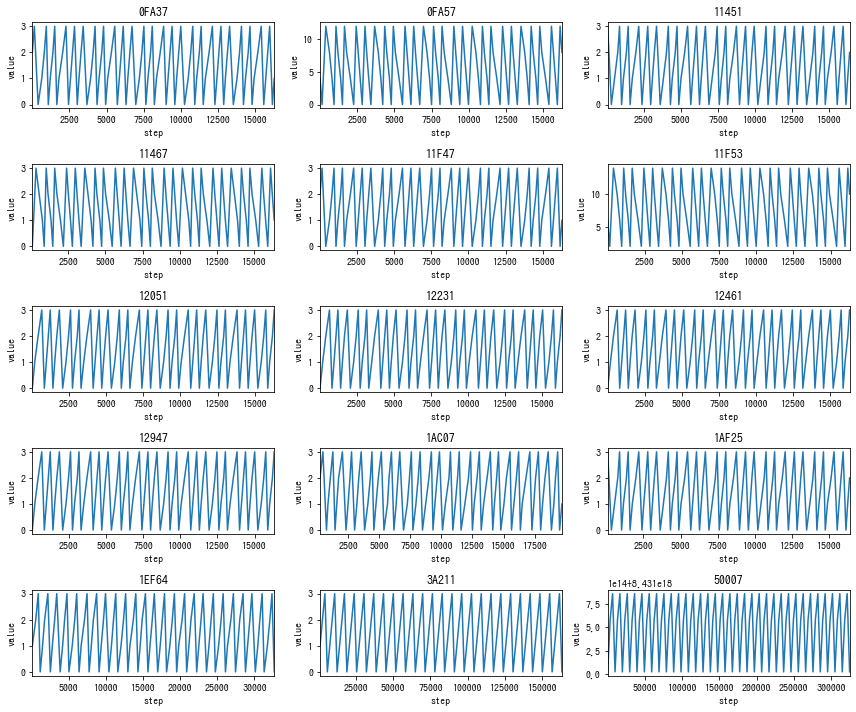

In [90]:
# 変数の時系列変化をプロット
fig = plt.figure(figsize=(12,10))
for i, feature in enumerate(pattern_feature):
    ax = fig.add_subplot(5,3,i+1)
    df.loc[df.feature==feature, "value"][:100].plot(ax=ax, style="-") # 最初の100ポイントをプロット
    ax.set(title=feature, ylabel="value",
          xlabel="step")
plt.tight_layout()

いずれもパターン的に変化する信号のようなので、除去する。

In [91]:
# set(集合)に変換して、差集合をとったのち、listに戻す
feature_multival_wo_pattern = list(set(feature_multivalue) - set(pattern_feature))
feature_multival_wo_pattern[:5] # 最初の5つを表示

['1AC41', '3D055', '2A006', '11915', '32F20']

In [92]:
len(feature_multival_wo_pattern) # 89個残った

89

#### お互いに相関の高いペアを除去

異なる変数(センサー)同士で相関を取るには、共通の時間軸が必要なので、まず共通の時間軸を作成し、それにあわせてサンプリングを行う。  
今回は0.1s(10Hz)で作成する。

In [95]:
df.head(3)

,vin,time1,time2,feature,value
0,21,201604200627,0.295909,0FA53,0.0
1,21,201604200627,0.295909,0FA57,4.0
2,21,201604200627,0.295909,0FA43,0.0


まず、時間単位を0.1s単位に丸める

In [116]:
df_rounded = df.loc[df.feature.isin(feature_multival_wo_pattern)].copy() # dfから、対象の変数のみを抜き出して、コピーする。
df_rounded["rounded_time2"] = np.round(df_rounded.time2, 1) # time2を小数点以下1桁(0.1)で丸める
df_rounded = df_rounded.groupby(["vin", "time1","rounded_time2","feature"])["value"].median() # 中央値で集約
df_rounded = df_rounded.to_frame().reset_index() # seriesをdataframeに変えたあと、groupbyされたindexを解除
df_rounded.head(3)

,vin,time1,rounded_time2,feature,value
0,21,201604200627,0.3,11913,13.0
1,21,201604200627,0.3,11915,1.5
2,21,201604200627,0.3,11927,-12.3


このままだと0.1秒単位ではあるが、欠けている秒があったり、欠けているセンサーの値があったりするので、pandasのresample機能を使用して、0.1秒間隔で隙間なくdataframeを作り、欠けている値は補間する。

まずは時間軸をindexに持っていく。

In [132]:
# 横持ちに変更
df_pivot = df_rounded.pivot_table(values="value", index=["vin", "time1", "rounded_time2"],
                      columns="feature").reset_index()
df_pivot.head()

feature,vin,time1,rounded_time2,11913,11915,11927,11947,12013,12033,12217,...,3D055,3D064,3D151,3D157,3D177,3D604,3D667,3E206,3E801,46003
0,21,201604200627,0.3,13.0,1.5,-12.30,-7.70,0.0,0.0,0.0,...,1.0,1.0,1.3,1.0,14.5,0.0,5.0,NaN,36.55914,NaN
1,21,201604200627,0.4,13.0,1.5,-12.25,-7.65,0.0,0.0,0.0,...,1.0,1.0,1.4,1.0,14.5,0.0,5.0,1.0,36.55914,NaN
2,21,201604200627,0.5,14.0,1.5,-12.30,-7.70,0.0,0.0,0.0,...,1.0,1.0,1.4,1.0,14.5,0.0,5.0,0.0,36.55914,NaN
3,21,201604200627,0.6,13.0,1.5,-12.25,-7.65,0.0,0.0,0.0,...,1.0,1.0,1.5,1.0,14.5,0.0,5.0,0.0,36.55914,NaN
4,21,201604200627,0.7,13.0,1.0,-12.30,-7.70,0.0,0.0,0.0,...,1.0,1.0,1.5,1.0,14.5,0.0,5.0,0.0,36.55914,NaN


In [133]:
# 今は1ファイルのみを扱っているのでvin, time1(計測開始日時)を落とす。rounded_time2をindexにする。
df_pivot = df_pivot.drop(["vin", "time1"], axis=1).set_index("rounded_time2")

次に時間軸をtimestamp型またはtimedelta型に変更する。

In [135]:
# インデックスをint型からtimedelta型(単位はsecondに変更する
# これによって、resampleが可能になる
df_pivot.index = pd.to_timedelta(df_pivot.index, unit="s") # unit="s" -> 秒単位

In [137]:
df_pivot.head(3)

feature,11913,11915,11927,11947,12013,12033,12217,12227,12247,12417,...,3D055,3D064,3D151,3D157,3D177,3D604,3D667,3E206,3E801,46003
rounded_time2,,,,,,,,,,,,,,,,,,,,,
00:00:00.300000,13.0,1.5,-12.30,-7.70,0.0,0.0,0.0,0.0,5.098039,919.0,...,1.0,1.0,1.3,1.0,14.5,0.0,5.0,NaN,36.55914,NaN
00:00:00.400000,13.0,1.5,-12.25,-7.65,0.0,0.0,0.0,0.0,5.098039,916.5,...,1.0,1.0,1.4,1.0,14.5,0.0,5.0,1.0,36.55914,NaN
00:00:00.500000,14.0,1.5,-12.30,-7.70,0.0,0.0,0.0,0.0,5.098039,914.0,...,1.0,1.0,1.4,1.0,14.5,0.0,5.0,0.0,36.55914,NaN


最後にresampleを行う。補間の方法は(A)前の値を使用 (B)線形補間 (C)近い値を使用のいずれかが一般的であろう。

In [207]:
# (A)前の値を使用
df_filledA = df_pivot.resample("100ms").ffill().fillna(method="ffill")
df_filledA.head(3) # 初めての値が出てくるまでは、nullが発生する

feature,11913,11915,11927,11947,12013,12033,12217,12227,12247,12417,...,3D055,3D064,3D151,3D157,3D177,3D604,3D667,3E206,3E801,46003
rounded_time2,,,,,,,,,,,,,,,,,,,,,
00:00:00.300000,13.0,1.5,-12.30,-7.70,0.0,0.0,0.0,0.0,5.098039,919.0,...,1.0,1.0,1.3,1.0,14.5,0.0,5.0,NaN,36.55914,NaN
00:00:00.400000,13.0,1.5,-12.25,-7.65,0.0,0.0,0.0,0.0,5.098039,916.5,...,1.0,1.0,1.4,1.0,14.5,0.0,5.0,1.0,36.55914,NaN
00:00:00.500000,14.0,1.5,-12.30,-7.70,0.0,0.0,0.0,0.0,5.098039,914.0,...,1.0,1.0,1.4,1.0,14.5,0.0,5.0,0.0,36.55914,NaN


In [209]:
# (B)線形補間を使用
df_filledB = df_pivot.resample("100ms").interpolate().interpolate()
df_filledB.head(3) # 初めての値が出てくるまでと、最後の値が出てからは、nullが発生する

feature,11913,11915,11927,11947,12013,12033,12217,12227,12247,12417,...,3D055,3D064,3D151,3D157,3D177,3D604,3D667,3E206,3E801,46003
rounded_time2,,,,,,,,,,,,,,,,,,,,,
00:00:00.300000,13.0,1.5,-12.30,-7.70,0.0,0.0,0.0,0.0,5.098039,919.0,...,1.0,1.0,1.3,1.0,14.5,0.0,5.0,NaN,36.55914,NaN
00:00:00.400000,13.0,1.5,-12.25,-7.65,0.0,0.0,0.0,0.0,5.098039,916.5,...,1.0,1.0,1.4,1.0,14.5,0.0,5.0,1.0,36.55914,NaN
00:00:00.500000,14.0,1.5,-12.30,-7.70,0.0,0.0,0.0,0.0,5.098039,914.0,...,1.0,1.0,1.4,1.0,14.5,0.0,5.0,0.0,36.55914,NaN


In [224]:
# (c)近い値を使用
df_tmp = df_pivot.resample("100ms").nearest()

# (B)のときのようにやると、なぜか時系列indexだとエラーになるので、一旦indexを外してから処理
df_tmp_index = df_tmp.index
df_filledC = df_tmp.reset_index(drop=True).interpolate(method="nearest").set_index(df_tmp_index)
df_filledC.head(3) # 初めての値が出てくるまでと、最後の値が出てからは、nullが発生する

feature,11913,11915,11927,11947,12013,12033,12217,12227,12247,12417,...,3D055,3D064,3D151,3D157,3D177,3D604,3D667,3E206,3E801,46003
rounded_time2,,,,,,,,,,,,,,,,,,,,,
00:00:00.300000,13.0,1.5,-12.30,-7.70,0.0,0.0,0.0,0.0,5.098039,919.0,...,1.0,1.0,1.3,1.0,14.5,0.0,5.0,NaN,36.55914,NaN
00:00:00.400000,13.0,1.5,-12.25,-7.65,0.0,0.0,0.0,0.0,5.098039,916.5,...,1.0,1.0,1.4,1.0,14.5,0.0,5.0,1.0,36.55914,NaN
00:00:00.500000,14.0,1.5,-12.30,-7.70,0.0,0.0,0.0,0.0,5.098039,914.0,...,1.0,1.0,1.4,1.0,14.5,0.0,5.0,0.0,36.55914,NaN


今回は (C)近い値を使用 を採用する。

In [232]:
df_filled = df_filledC

In [233]:
# 差分の相関行列を計算
df_corr = df_filled.diff().corr()
df_corr.head(3)

feature,11913,11915,11927,11947,12013,12033,12217,12227,12247,12417,...,3D055,3D064,3D151,3D157,3D177,3D604,3D667,3E206,3E801,46003
feature,,,,,,,,,,,,,,,,,,,,,
11913,1.000000,-0.089107,0.005196,0.005196,-0.004711,-0.007714,-0.002960,-0.006123,-0.002483,0.006029,...,0.010310,0.004858,0.013628,-0.004858,0.014629,-0.001250,0.000002,0.009698,0.013747,0.020667
11915,-0.089107,1.000000,0.001962,0.001962,-0.006124,-0.004767,-0.007809,-0.011410,0.006844,-0.000765,...,-0.017054,-0.018089,-0.003025,0.018089,-0.010889,0.018613,-0.000002,0.004184,-0.010726,-0.016196
11927,0.005196,0.001962,1.000000,1.000000,0.022195,0.029994,0.034778,0.033537,0.005682,-0.020733,...,-0.008445,0.000004,-0.012807,-0.000004,0.010785,0.002534,-0.000004,-0.001252,0.000669,0.014775


In [234]:
high_corr_pairs = [(df_corr.columns[i], df_corr.columns[j])
                   for i,j in zip(*np.where(abs(df_corr) > 0.9)) if i < j]
high_corr_pairs[:5]

[('11927', '11947'),
 ('12217', '12227'),
 ('12247', '12457'),
 ('12417', '13F17'),
 ('12944', '12964')]

In [417]:
# そのままの値の相関行列も計算
df_corr_raw = df_filled.corr()
high_corr_pairs_raw = [(df_corr_raw.columns[i], df_corr_raw.columns[j])
                   for i,j in zip(*np.where(abs(df_corr_raw) > 0.9)) if i < j]

In [14]:
# センサーコードを一部読み替え
df_feature_name = pd.read_csv("../data/interim/20190605_CAN/20190617_featureName.csv")
df_feature_name["key"] = df_feature_name["key"].str[2:] # scを取り除く
feature_code_dict = df_feature_name.set_index("key")["featureName"].to_dict() # dataframeを辞書形式に

In [236]:
list(feature_code_dict.items())[:5]

[('11947', 'Steering Wheel Absolute Angle'),
 ('12013', 'Engine Torque Actual'),
 ('12217', 'Accelerator Actual Position'),
 ('12417', 'Engine Speed'),
 ('1AF67', 'Master Cylinder Pressure')]

In [420]:
high_corr_pairs_name = [(feature_code_dict[i] if i in feature_code_dict else i,
                         feature_code_dict[j] if j in feature_code_dict else j)
                         for i,j in set(high_corr_pairs) | set(high_corr_pairs_raw)]
high_corr_pairs_name

[('1E926', '2A006'),
 ('12227', '13F47'),
 ('Engine Speed', '13F17'),
 ('3D055', '3D157'),
 ('13F47', '13F57'),
 ('Wheel Speed(Front Right)', 'Wheel Speed(Rear Right)'),
 ('1E946', '2A046'),
 ('2A214', 'Brake Pedal Switch Active'),
 ('Engine Torque Actual', '12227'),
 ('1E946', '1E966'),
 ('3BA07', 'Mileage Information'),
 ('Engine Torque Actual', '12033'),
 ('32F20', '3BA43'),
 ('3D052', '3D055'),
 ('Wheel Speed(Front Right)', 'Wheel Speed(Front Left)'),
 ('Outside Air Temperature', '3E801'),
 ('Wheel Speed(Front Left)', 'Wheel Speed(Rear Right)'),
 ('1E906', '1E926'),
 ('Wheel Speed(Rear Right)', 'Vehicle Speed'),
 ('1E823', '1E843'),
 ('3BA43', '3BA60'),
 ('1E906', '2A006'),
 ('1E966', '2A046'),
 ('13F47', 'Fuel Consumption'),
 ('3D064', '3D667'),
 ('Wheel Speed(Front Right)', 'Vehicle Speed'),
 ('1E926', '2A026'),
 ('3D055', '3D064'),
 ('3D014', '3D604'),
 ('3D064', '3D157'),
 ('Accelerator Actual Position', '12227'),
 ('1EF17', 'Yaw Rate 1(learmed data)'),
 ('Wheel Speed(Front Lef

機械的にセンサー番号が若い方だけ残す方法、定性的に残す方法など、いくつかある。ここでは、センサーに名前がついているものを極力残し、センサーに名前がないものは、頻出するセンサーをなるべく残すように、いくつかの変数を除去した。

In [479]:
# 除去する変数
feature_removed_w_corr = ["2A214", "3E801", "12227", "12033", "3BA07",
                          "13F47", "1E823", "1E926", "2A046", "1E966",
                          "3BA43", "2A006", "12964", "11927", "12457",
                          "13F57", "3B801", "1E946", "3C367", "Engine Torque Actual",
                          "13F17", 'Wheel Speed(Front Left)', 'Wheel Speed(Rear Right)',
                          "Wheel Speed(Front Right)", "Wheel Speed(Rear Left)",
                          "1E843", "2A026", "1EF17", "3BA60", "3D014", "3D052",
                          "3D064", "3D157"]

# 念の為、相関が高いペアが残らないかチェック
[(i, j) for i,j in high_corr_pairs_name 
 if (i not in feature_removed_w_corr) and (j not in feature_removed_w_corr)]

[('Outside Air Temperature', 'Mileage Information')]

外気温とマイレージはたまたま相関が高くなったと思われるので、除外しない。

In [480]:
# 名前はセンサーコードに置き換えておく

# コード:名前 の辞書から名前:コード の辞書を作成
code_feature_dict = {featureName: code for code, featureName in feature_code_dict.items()} 

# 置き換える
feature_removed_w_corr_code = [code_feature_dict[name] if name in code_feature_dict else name
                          for name in feature_removed_w_corr]

In [481]:
feature_multival_wo_pattern_no_corr = list(
    set(feature_multival_wo_pattern) - set(feature_removed_w_corr_code))
feature_multival_wo_pattern_no_corr[:5]

['3A107', '12905', '1AC41', '3D055', '46003']

In [482]:
len(feature_multival_wo_pattern_no_corr)

56

In [483]:
# 使用する変数リストをcsvで残しておく
pd.Series(feature_multival_wo_pattern_no_corr).to_csv(
    "../data/interim/feature_multival_wo_pattern_no_corr.csv")

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


### 1時間分のファイルの作成

#### ファイルの連結

In [189]:
filenames = ["SUZUKI_YSB-021_MRR_2016-04-20_06-27_0001.BLF.csv",
             "SUZUKI_YSB-021_MRR_2016-04-20_06-37_0002.BLF.csv",
             "SUZUKI_YSB-021_MRR_2016-04-20_06-47_0003.BLF.csv",
             "SUZUKI_YSB-021_MRR_2016-04-20_06-57_0004.BLF.csv",
             "SUZUKI_YSB-021_MRR_2016-04-20_07-08_0005.BLF.csv",
             "SUZUKI_YSB-021_MRR_2016-04-20_07-18_0006.BLF.csv",
             "SUZUKI_YSB-021_MRR_2016-04-20_07-28_0007.BLF.csv"]

In [484]:
time_gap = 5 # fileとfileの間の時間。5秒と置く。
time_offset = 0 # time2の補正値
df_list = [] # dataframeを連結するための入れ物

for filename in filenames:
    # 読み込み
    df_tmp = pd.read_csv("../data/interim/20190605_CAN/103.486_CAR1V21_HDD2/Job1/"
                         + filename,
                        names=['vin', 'time1', 'time2', 'feature', 'value'])
    max_time = df_tmp.time2.max() # 時間の最後の値をメモしておく
    
    # 不要なfeatureを落とす
    df_tmp = df_tmp[df_tmp.feature.isin(feature_multival_wo_pattern_no_corr)]
    df_tmp["time2"] = df_tmp["time2"] + time_offset # time2に補正値を足す
    df_list.append(df_tmp.drop("time1", axis=1)) # time1はもう不要なので落とす
    time_offset = max_time + time_gap # time2の最後の値にfileとfileの間の時間を足して、補正値を更新。

df_concat = pd.concat(df_list) # 連結

In [485]:
df_concat.shape

(8180579, 4)

In [486]:
df_concat.head(3)

,vin,time2,feature,value
23,21,0.296461,12464,1.0
26,21,0.296461,12437,1260.0
27,21,0.296461,12417,919.0


In [487]:
# df_concatから、対象の変数のみを抜き出して、コピーする。
df_con_rounded = df_concat.loc[df_concat.feature.isin(feature_multival_wo_pattern)].copy() 
df_con_rounded["rounded_time2"] = np.round(df_con_rounded.time2, 1) # time2を小数点以下1桁(0.1)で丸める
df_con_rounded = df_con_rounded.groupby(["vin", "rounded_time2","feature"])["value"].median() # 中央値で集約
df_con_rounded = df_con_rounded.to_frame().reset_index() # seriesをdataframeに変えたあと、groupbyされたindexを解除

#### (Optional) 補間

後で1秒毎に集約するので、やらなくても良い。

In [488]:
# 横持ちに変更
df_con_pivot = df_con_rounded.pivot_table(values="value", index=["vin", "rounded_time2"],
                      columns="feature").reset_index()

In [489]:
df_con_pivot.vin.nunique()

1

In [490]:
# 今回は1台のみなのでvinを落とす。rounded_time2をindexにする。
df_con_pivot = df_con_pivot.drop(["vin"], axis=1).set_index("rounded_time2")

# インデックスをint型からtimedelta型(単位はsecondに変更する
# これによって、resampleが可能になる
df_con_pivot.index = pd.to_timedelta(df_con_pivot.index, unit="s") # unit="s" -> 秒単位

# (c)近い値を使用
df_tmp = df_con_pivot.resample("100ms").nearest()

# (B)のときのようにやると、なぜか時系列indexだとエラーになるので、一旦indexを外してから処理
df_tmp_index = df_tmp.index
df_con_filled = df_tmp.reset_index(drop=True).interpolate(method="nearest").set_index(df_tmp_index)

In [491]:
df_con_filled.shape

(12045, 56)

In [492]:
# isnaでnullを判定したのち、sumで各列の合計を取り、sort_values(ascending=False)で降順に並び替えている
df_con_filled.isna().sum().sort_values(ascending=False).head() 
# 初めての値が出てくるまでと、最後の値が出てからは、nullが発生する

feature
46003    9
3BA37    2
3E206    2
3B947    2
3B957    2
dtype: int64

#### 微調整&保存

In [493]:
# 最初のtimedeltaが0だと後のresamplingがきれいにできるので、0の行を足しておく。
# ここでは名前がtimedelta(0)の行(Series)をappendで足したあとに、再度ソートしている。

df_con_filled = (df_con_filled.dropna()
                 .append(pd.Series({col:np.nan for col in df_con_filled.columns}, 
                                   name=pd.to_timedelta(0)))
                 .sort_index())

In [494]:
df_con_filled.to_csv("../data/interim/df_con_filled.csv")

### (Optional)7月までに作成したファイルを利用する場合

In [445]:
# フォルダのパス
PATH_DATA_PRO_SUB2_PKL = pathlib.Path("../data/processed/subject02/pickle") 
PATH_DATA_PRO_SUB2 = pathlib.Path("../data/processed/subject02") 

In [446]:
# pickleファイルを読み込んだ結果を返す関数
def read_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)
    
# pickleファイルの読み込み
lsNameCode = read_pickle(PATH_DATA_PRO_SUB2_PKL/"20190702_lsNameCode17_sampFreq100.pkl")
lsNameEnglishCode = read_pickle(PATH_DATA_PRO_SUB2_PKL/"20190702_lsNameEnglishCode17_sampFreq100.pkl")
lsNpCanResampled = read_pickle(PATH_DATA_PRO_SUB2_PKL/"20190702_lsNpCanResampled17_sampFreq100.pkl")
timeSeriesStart2End = read_pickle(PATH_DATA_PRO_SUB2_PKL/"20190702_timeSeriesStart2EndUse23_sampFreq100.pkl")
pdFeatureProfile = read_pickle(PATH_DATA_PRO_SUB2_PKL/"20190702_pdFeatureProfileUse23_sampFreq100.pkl")

In [447]:
# 特徴量コード: 特徴量の名前　の読み替え用辞書
feature_code_dict = pdFeatureProfile.set_index("feature")["featureName"].to_dict()

In [448]:
# 上記の読み替え辞書を使用して、lsNameCodeのための読み替え辞書を作成。読み替え辞書にないcolについては、そのまま。
feature_code_dict_all = {col:feature_code_dict[col] if col in feature_code_dict else col
                         for col in lsNameCode}

In [6]:
timeSeriesStart2End

array([1.00000e-02, 2.00000e-02, 3.00000e-02, ..., 3.69898e+03,
       3.69899e+03, 3.69900e+03])

In [7]:
# コード: 値の時系列リストの辞書を用意して、DataFrameに変換
# indexはpandasで処理がしやすくなるよう、timedelta形式にしておく。今回の単位は秒(second)なので、unit="s"を指定。
df_made = pd.DataFrame({col:val for col, val in zip(lsNameCode, lsNpCanResampled)},
                 index=pd.to_timedelta(timeSeriesStart2End, unit="s"))

# 列名を読み替え辞書を使って変更
df_made.rename(columns=feature_code_dict, inplace=True)

df_made.head()

,Acceleration Sensor Value,Accelerator Actual Position,Brake Pedal Switch Active,Engine Coolant Temperature,Engine Speed,Fuel Level Actual Percent,Fuel Level Percent Average,Lateral Sensor Value,Master Cylinder Pressure,Mileage Information,Outside Air Temperature,Park Brake Switch Active,Steering Wheel Absolute Angle,Turn Left SW,Turn Right SW,Vehicle Speed,Yaw Rate 1(learmed data)
00:00:00.010000,0.0,0.0,1.0,49.0,919.0,92.156863,92.156863,0.0,28.3,8913.0,14.5,1.0,-7.7,0.0,0.0,0.0,0.025
00:00:00.020000,0.0,0.0,1.0,49.0,919.0,92.156863,92.156863,0.0,28.3,8913.0,14.5,1.0,-7.7,0.0,0.0,0.0,0.025
00:00:00.030000,0.0,0.0,1.0,49.0,919.0,92.156863,92.156863,0.0,28.3,8913.0,14.5,1.0,-7.7,0.0,0.0,0.0,0.025
00:00:00.040000,0.0,0.0,1.0,49.0,919.0,92.156863,92.156863,0.0,28.3,8913.0,14.5,1.0,-7.7,0.0,0.0,0.0,0.025
00:00:00.050000,0.0,0.0,1.0,49.0,919.0,92.156863,92.156863,0.0,28.3,8913.0,14.5,1.0,-7.7,0.0,0.0,0.0,0.025


In [8]:
# 最初のtimedeltaが0だと後のresamplingがきれいにできるので、0の行を足しておく。

df_made = df_made.append(pd.Series({col:np.nan for col in df.columns}, name=pd.to_timedelta(0))).sort_index()

## GMMによる短期運転行動のクラスタリング

今回は1時間のデータセットを使用して、1秒毎の運転行動をクラスタリングする。  

In [9]:
df = pd.read_csv("../data/interim/df_con_filled.csv", index_col="rounded_time2") # 上記で作成したファイルを使用
# df = df_made.copy() # 7月末までに作成したファイルを利用する場合はこちら

df.index = pd.to_timedelta(df.index)

In [12]:
# センサーコードを一部読み替え
df_feature_name = pd.read_csv("../data/interim/20190605_CAN/20190617_featureName.csv")
df_feature_name["key"] = df_feature_name["key"].str[2:] # scを取り除く
feature_code_dict = df_feature_name.set_index("key")["featureName"].to_dict() # dataframeを辞書形式に

In [13]:
df = df.rename(columns=feature_code_dict) # feature_code_dictを使ってコードを一部読み替え
df.head()

,11913,11915,Steering Wheel Absolute Angle,Accelerator Actual Position,12247,Engine Speed,12437,12464,12905,12925,...,Park Brake Switch Active,3D046,3D047,3D055,3D151,Outside Air Temperature,3D604,3D667,3E206,Mileage Information
rounded_time2,,,,,,,,,,,,,,,,,,,,,
00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:00:00.900000,13.5,1.0,-7.7,0.0,5.098039,916.00,1260.0,1.0,0.0,298.0,...,1.0,0.0,0.0,1.0,1.6,14.5,0.0,5.0,0.0,8913.0
00:00:01,13.0,2.0,-7.7,0.0,5.098039,917.25,1260.0,1.0,0.0,298.0,...,1.0,0.0,0.0,1.0,1.6,14.5,0.0,5.0,0.0,8913.0
00:00:01.100000,13.0,1.0,-7.7,0.0,5.098039,915.50,1260.0,1.0,0.0,298.0,...,1.0,0.0,0.0,1.0,1.6,14.5,0.0,5.0,0.0,8913.0
00:00:01.200000,13.5,2.0,-7.7,0.0,5.098039,914.00,1260.0,1.0,0.0,297.0,...,1.0,0.0,0.0,1.0,1.6,14.5,0.0,5.0,0.0,8913.0


In [764]:
df.shape

(12037, 56)

### 変数の選択

- 混合ガウスモデルは、各変数が混合正規分布に従い、また各クラスタが多次元正規分布に従うことを前提としている。すなわち、カテゴリ的な値や、正規分布からかけ離れたような分布を取る変数は想定されていない。
- 混合ガウスモデルを使う場合、離散値系の変数を入れると異常に尤度が高くなってしまうため、離散値系の変数ばかり選択してしまう。  
- 一応、混合ポアソンモデルというモデルもあるのだが、scipyなど有名なライブラリには実装されておらず、一から実装する必要があり、かなり労力がかかる。  
- また、仮に混合ポアソンモデルを使用したとしても、血液型(O, A, B, AB)のように、順番を決めにくい(O < A < B < ABという順番は自然ではない)変数、いわゆるカテゴリ系(**名義尺度**ともいう)の変数は、ポアソンモデルでも使用できない。  
- そういった"分布が仮定しにくい"変数に対しては、K-平均法や階層クラスタリングなどの、分布を明確に仮定しない、いわゆる**ノンパラメトリック**なクラスタリング手法を取ったほうが良いことがある。  
- K-平均法や階層クラスタリングについても、今後解説する予定である。

ここでは、GMMの利用に適した変数を選択した上で、GMMに適用する。

In [687]:
# 今回は1秒毎の運転行動のクラスタリングなので、1秒毎にサンプリングしたものをプロットする。
df_sampled_tmp = df.resample("1s").agg(np.mean)

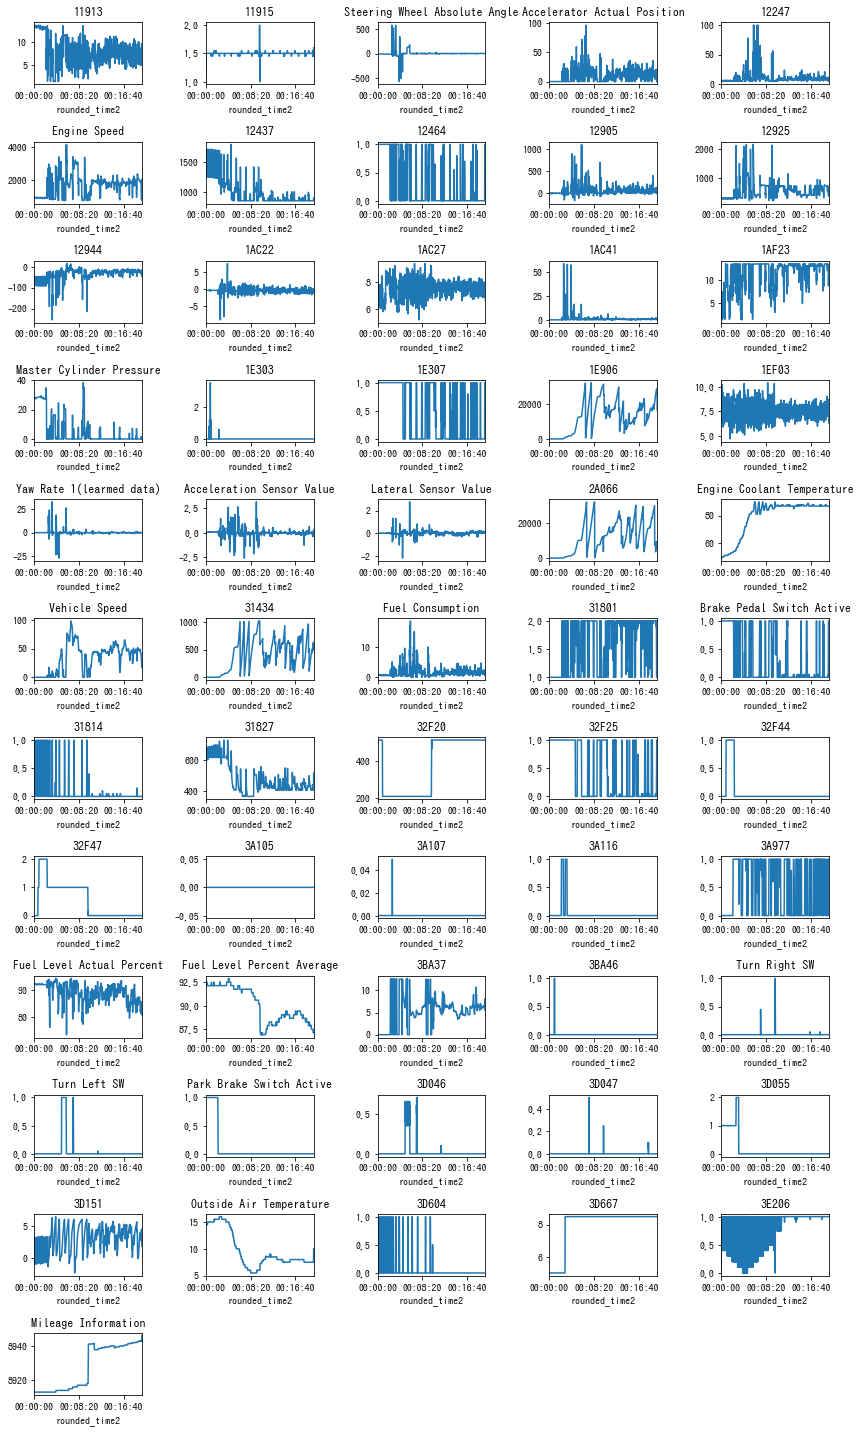

In [688]:
# 時系列プロット
fig = plt.figure(figsize=(12,20))
for i, feature in enumerate(df_sampled_tmp.columns):
    ax = fig.add_subplot(12, 5, i+1)
    df_sampled_tmp[feature].plot(ax=ax)
    ax.set(title=feature)
    
plt.tight_layout()

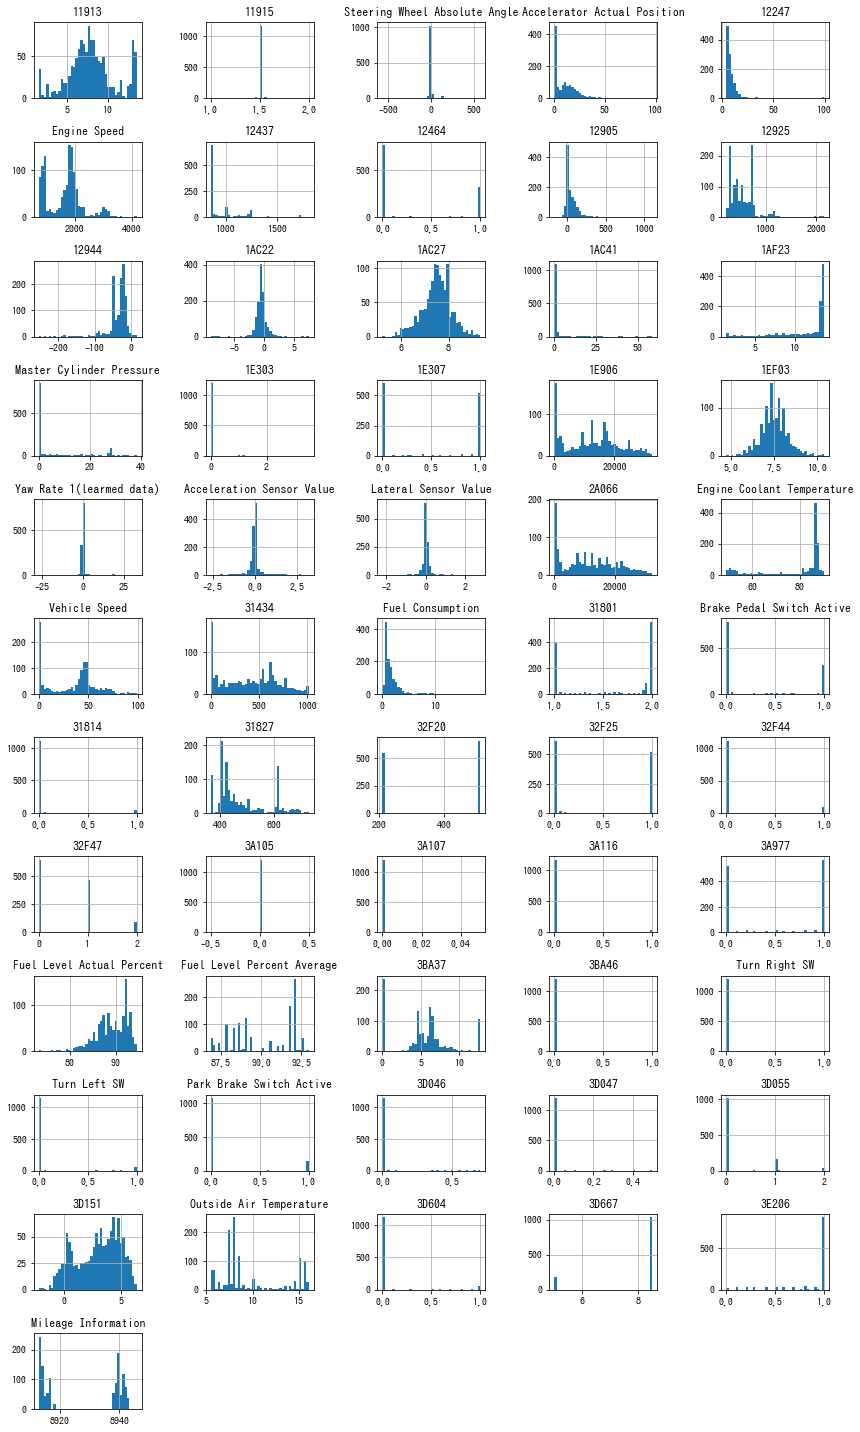

In [689]:
# ヒストグラム
fig = plt.figure(figsize=(12,20))
for i, feature in enumerate(df_sampled_tmp.columns):
    ax = fig.add_subplot(12, 5, i+1)
    df_sampled_tmp[feature].hist(ax=ax, bins=40)
    ax.set(title=feature)
    
plt.tight_layout()

In [690]:
# 以下の変数を使用する
feature_for_gmm = ["11913", "12247", "Accelerator Actual Position", 
                   "Engine Speed", "12905", "12925", "12944", "1AC22", "1AC27", 
                   "1E906", "1EF03", "2A066","Engine Coolant Temperature",
                   "Vehicle Speed", "31434", "Fuel Consumption", "31827",
                   "Fuel Level Actual Percent", "Fuel Level Percent Average",
                   "3BA37", "3D151", "Outside Air Temperature", "Mileage Information",
                   "Steering Wheel Absolute Angle", "Yaw Rate 1(learmed data)",
                   "Acceleration Sensor Value", "Lateral Sensor Value"]
# 角度系(下2行)は殆ど0近辺なので悩ましいが、運転行動の把握という目的を考えて、含めることとする

In [691]:
len(feature_for_gmm)

27

In [692]:
df_selected = df[feature_for_gmm] # 選んだ変数のみに限定

### 特徴量の加工

#### 集約

In [711]:
# 差分を計算
df_diff = df_selected.diff() 

# 1秒毎にリサンプリング。集約する際に、mean, max, minの3種類で集約する場合。
# 辞書形式で渡すと、列にその名前を付けて集約することができる
df_sampled = df_selected.resample("1s",).agg({"mean":np.mean, "max":np.max, "min":np.min})
df_diff_sampled = (df_diff
                   .resample("1s").agg({"diff_mean":np.mean, "diff_max":np.max, "diff_min":np.min})
                   .dropna())

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  
/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  


In [712]:
df_sampled_test.head(3)

mean                                                           \
feature        11913     12247 Accelerator Actual Position Engine Speed 12905   
rounded_time2                                                                   
00:00:00       13.50  5.098039                         0.0       916.00   0.0   
00:00:01       13.30  5.098039                         0.0       916.75   0.0   
00:00:02       13.45  5.098039                         0.0       921.10  -0.7   

                                               ...                       min  \
feature         12925 12944 1AC22 1AC27 1E906  ... Fuel Level Actual Percent   
rounded_time2                                  ...                             
00:00:00       298.00 -49.0 -0.36  7.50   0.0  ...                 92.156863   
00:00:01       297.85 -48.0 -0.36  7.15   0.0  ...                 92.156863   
00:00:02       297.95 -48.2 -0.36  6.45   0.0  ...                 92.156863   

                                                                              \
feature       Fuel Level Percent Average 3BA37 3D151 Outside Air Temperature   
rounded_time2                                                                  
00:00:00                       92.156863   0.0   1.6                    14.5   
00:00:01                       92.156863   0.0   1.6                    14.5   
00:00:02                       92.156863   0.0   2.0                    14.5   

                                                                 \
feature       Mileage Information Steering Wheel Absolute Angle   
rounded_time2                                                     
00:00:00                   8913.0                          -7.7   
00:00:01                   8913.0                          -7.7   
00:00:02                   8913.0                          -7.7   

                                                                  \
feature       Yaw Rate 1(learmed data) Acceleration Sensor Value   
rounded_time2                                                      
00:00:00                         0.000                    0.0625   
00:00:01                        -0.005                    0.0000   
00:00:02                         0.000                    0.0625   

                                    
feature       Lateral Sensor Value  
rounded_time2                       
00:00:00                       0.0  
00:00:01                       0.0  
00:00:02                       0.0  

[3 rows x 81 columns]

In [713]:
df_diff_sampled.shape

(1204, 81)

In [714]:
df_diff_sampled.head(3)

diff_mean                                                     \
feature           11913     12247 Accelerator Actual Position Engine Speed   
rounded_time2                                                                
00:00:01          -0.05  0.000000                         0.0         0.10   
00:00:02           0.10  0.000000                         0.0         0.25   
00:00:03          -0.05  0.156863                         0.0         0.85   

                                                   ...  \
feature       12905 12925 12944 1AC22 1AC27 1E906  ...   
rounded_time2                                      ...   
00:00:01       0.00   0.0   0.1   0.0  0.00   0.0  ...   
00:00:02       0.00   0.0   0.0   0.0  0.05   0.0  ...   
00:00:03      -0.25   0.1   0.6   0.0 -0.05   0.0  ...   

                               diff_min                                   \
feature       Fuel Level Actual Percent Fuel Level Percent Average 3BA37   
rounded_time2                                                              
00:00:01                            0.0                        0.0   0.0   
00:00:02                            0.0                        0.0   0.0   
00:00:03                            0.0                        0.0   0.0   

                                                                 \
feature       3D151 Outside Air Temperature Mileage Information   
rounded_time2                                                     
00:00:01        0.0                     0.0                 0.0   
00:00:02        0.0                     0.0                 0.0   
00:00:03        0.0                     0.0                 0.0   

                                                                      \
feature       Steering Wheel Absolute Angle Yaw Rate 1(learmed data)   
rounded_time2                                                          
00:00:01                                0.0                   -0.055   
00:00:02                                0.0                   -0.040   
00:00:03                               -0.1                   -0.030   

                                                              
feature       Acceleration Sensor Value Lateral Sensor Value  
rounded_time2                                                 
00:00:01                        -0.0625              -0.0625  
00:00:02                         0.0000              -0.0625  
00:00:03                         0.0000              -0.0625  

[3 rows x 81 columns]

In [715]:
# 階層インデックス(multi-indexとも)はこのような形で格納されている
df_sampled.columns.values[:5]

array([('mean', '11913'), ('mean', '12247'),
       ('mean', 'Accelerator Actual Position'), ('mean', 'Engine Speed'),
       ('mean', '12905')], dtype=object)

In [716]:
# このような1階層の列になおしたい
["_".join(col) for col in df_sampled.columns][:5]

['mean_11913',
 'mean_12247',
 'mean_Accelerator Actual Position',
 'mean_Engine Speed',
 'mean_12905']

In [717]:
# columnsに目的の列を代入すると、変更できる
df_sampled.columns = ["_".join(col) for col in df_sampled.columns]
df_sampled.head(3)

,mean_11913,mean_12247,mean_Accelerator Actual Position,mean_Engine Speed,mean_12905,mean_12925,mean_12944,mean_1AC22,mean_1AC27,mean_1E906,...,min_Fuel Level Actual Percent,min_Fuel Level Percent Average,min_3BA37,min_3D151,min_Outside Air Temperature,min_Mileage Information,min_Steering Wheel Absolute Angle,min_Yaw Rate 1(learmed data),min_Acceleration Sensor Value,min_Lateral Sensor Value
rounded_time2,,,,,,,,,,,,,,,,,,,,,
00:00:00,13.50,5.098039,0.0,916.00,0.0,298.00,-49.0,-0.36,7.50,0.0,...,92.156863,92.156863,0.0,1.6,14.5,8913.0,-7.7,0.000,0.0625,0.0
00:00:01,13.30,5.098039,0.0,916.75,0.0,297.85,-48.0,-0.36,7.15,0.0,...,92.156863,92.156863,0.0,1.6,14.5,8913.0,-7.7,-0.005,0.0000,0.0
00:00:02,13.45,5.098039,0.0,921.10,-0.7,297.95,-48.2,-0.36,6.45,0.0,...,92.156863,92.156863,0.0,2.0,14.5,8913.0,-7.7,0.000,0.0625,0.0


In [718]:
# df_diff_sampledも同様
df_diff_sampled.columns = ["_".join(col) for col in df_diff_sampled.columns]

In [719]:
# 2つのdfを横に連結させる。今回はindexが共通なので、joinが便利である
df_all_tmp = df_sampled.join(df_diff_sampled, how="inner")

In [720]:
df_all_tmp.head(3)

,mean_11913,mean_12247,mean_Accelerator Actual Position,mean_Engine Speed,mean_12905,mean_12925,mean_12944,mean_1AC22,mean_1AC27,mean_1E906,...,diff_min_Fuel Level Actual Percent,diff_min_Fuel Level Percent Average,diff_min_3BA37,diff_min_3D151,diff_min_Outside Air Temperature,diff_min_Mileage Information,diff_min_Steering Wheel Absolute Angle,diff_min_Yaw Rate 1(learmed data),diff_min_Acceleration Sensor Value,diff_min_Lateral Sensor Value
rounded_time2,,,,,,,,,,,,,,,,,,,,,
00:00:01,13.30,5.098039,0.0,916.750,0.0,297.85,-48.00,-0.36,7.15,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.055,-0.0625,-0.0625
00:00:02,13.45,5.098039,0.0,921.100,-0.7,297.95,-48.20,-0.36,6.45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.040,0.0000,-0.0625
00:00:03,13.30,5.745098,0.0,921.825,-0.8,298.65,-46.05,-0.36,6.85,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.1,-0.030,0.0000,-0.0625


In [721]:
df_all_tmp.shape

(1204, 162)

#### 再度相関から変数選定

In [722]:
# 相関行列を計算
df_corr_all = df_all_tmp.corr()
high_corr_pairs_all = [(df_corr_all.columns[i], df_corr_all.columns[j])
                   for i,j in zip(*np.where(abs(df_corr_all) > 0.9)) if i < j]

In [723]:
high_corr_pairs_all

[('mean_12247', 'max_12247'),
 ('mean_Accelerator Actual Position', 'max_Accelerator Actual Position'),
 ('mean_Accelerator Actual Position', 'min_Accelerator Actual Position'),
 ('mean_Engine Speed', 'max_Engine Speed'),
 ('mean_Engine Speed', 'min_Engine Speed'),
 ('mean_12905', 'max_12905'),
 ('mean_12925', 'max_12925'),
 ('mean_12925', 'min_12925'),
 ('mean_12944', 'max_12944'),
 ('mean_12944', 'min_12944'),
 ('mean_1AC22', 'max_1AC22'),
 ('mean_1AC22', 'min_1AC22'),
 ('mean_1E906', 'max_1E906'),
 ('mean_1E906', 'min_1E906'),
 ('mean_2A066', 'max_2A066'),
 ('mean_2A066', 'min_2A066'),
 ('mean_Engine Coolant Temperature', 'mean_Outside Air Temperature'),
 ('mean_Engine Coolant Temperature', 'max_Engine Coolant Temperature'),
 ('mean_Engine Coolant Temperature', 'max_Outside Air Temperature'),
 ('mean_Engine Coolant Temperature', 'min_Engine Coolant Temperature'),
 ('mean_Engine Coolant Temperature', 'min_Outside Air Temperature'),
 ('mean_Vehicle Speed', 'max_Vehicle Speed'),
 ('mea

殆どの場合において、集約の方法同士で相関が高くなってしまっているので、集約はmean一種類で集約する。

In [724]:
df_sampled_mean_only = df_selected.resample("1s",).agg(np.mean)
df_diff_sampled_mean_only = (df_diff
                   .resample("1s").agg(np.mean)
                   .dropna())

# rsuffixで、右側のdataframe(df_diff_sample)の列名には、終わりに"_diff"がつくようになる
df_all_mean_only = (df_sampled_mean_only
                    .join(df_diff_sampled_mean_only, how="inner", rsuffix="_diff"))
df_all_mean_only.head()

feature,11913,12247,Accelerator Actual Position,Engine Speed,12905,12925,12944,1AC22,1AC27,1E906,...,Fuel Level Actual Percent_diff,Fuel Level Percent Average_diff,3BA37_diff,3D151_diff,Outside Air Temperature_diff,Mileage Information_diff,Steering Wheel Absolute Angle_diff,Yaw Rate 1(learmed data)_diff,Acceleration Sensor Value_diff,Lateral Sensor Value_diff
rounded_time2,,,,,,,,,,,,,,,,,,,,,
00:00:01,13.30,5.098039,0.0,916.750,0.00,297.85,-48.00,-0.3600,7.15,0.0,...,0.000000,0.0,0.0,0.04,0.0,0.0,0.0,-0.0005,0.0,0.0
00:00:02,13.45,5.098039,0.0,921.100,-0.70,297.95,-48.20,-0.3600,6.45,0.0,...,0.000000,0.0,0.0,0.04,0.0,0.0,0.0,0.0035,0.0,0.0
00:00:03,13.30,5.745098,0.0,921.825,-0.80,298.65,-46.05,-0.3600,6.85,0.0,...,0.000000,0.0,0.0,0.04,0.0,0.0,0.0,-0.0010,0.0,0.0
00:00:04,13.25,6.509804,0.0,926.800,-3.55,259.85,-82.30,-0.3615,7.25,0.0,...,0.039216,0.0,0.0,0.03,0.0,0.0,0.0,-0.0040,0.0,0.0
00:00:05,13.30,6.372549,0.0,917.825,-1.75,254.40,-87.60,-0.3780,7.20,0.0,...,0.000000,0.0,0.0,0.01,0.0,0.0,0.0,0.0035,0.0,0.0


In [725]:
# 相関行列を再度計算
df_corr_all_mean_only = df_all_mean_only.corr()
high_corr_pairs_all_mean_only = [
    (df_corr_all_mean_only.columns[i], df_corr_all_mean_only.columns[j])
    for i,j in zip(*np.where(abs(df_corr_all_mean_only) > 0.9)) if i < j]
high_corr_pairs_all_mean_only

[('Engine Coolant Temperature', 'Outside Air Temperature'),
 ('Fuel Level Percent Average', 'Mileage Information')]

これらは擬似的な相関と考えられるので、そのまま。

#### 再度プロットから変数選定

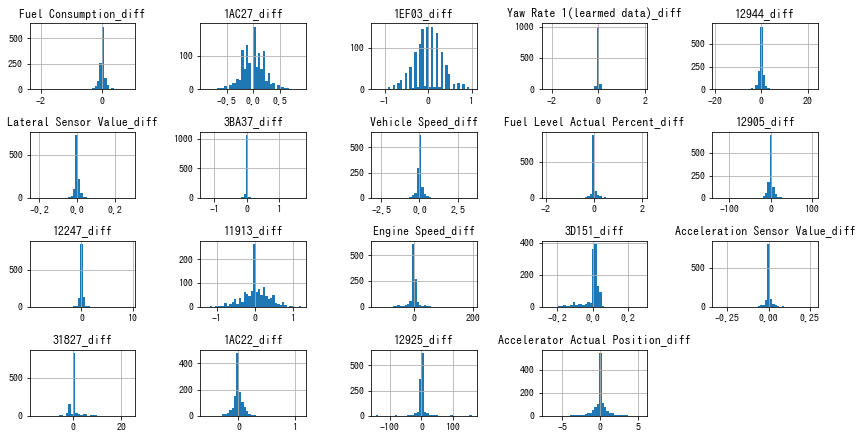

In [726]:
# 新たに作成したdiff系についてヒストグラム
fig = plt.figure(figsize=(12,9))
for i, feature in enumerate([col for col in df_all.columns if "diff" in col]):
    ax = fig.add_subplot(6, 5, i+1)
    df_all[feature].hist(ax=ax, bins=40)
    ax.set(title=feature)
    
plt.tight_layout()

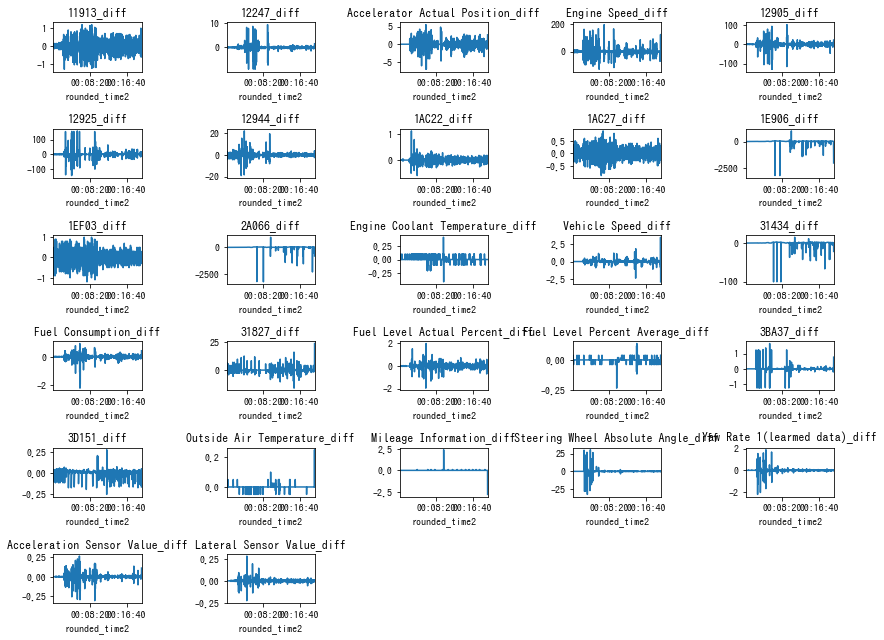

In [671]:
# 新たに作成したdiff系について時系列プロット
fig = plt.figure(figsize=(12,9))
for i, feature in enumerate([col for col in df_all.columns if "diff" in col]):
    ax = fig.add_subplot(6, 5, i+1)
    df_all[feature].plot(ax=ax)
    ax.set(title=feature)
    
plt.tight_layout()

In [728]:
# ほとんどが0となっている以下の変数を削除する。
# 1秒などの短期ではなく、より長期で集約すれば、結果は異なると思われる。
diff_remove_col = ["12247_diff", 
                   "1E906_diff", "2A066_diff", "Engine Coolant Temperature_diff",
                   "31434_diff", "Fuel Level Percent Average_diff",
                   "Outside Air Temperature_diff", "Mileage Information_diff",
                   "Steering Wheel Absolute Angle_diff", "Yaw Rate 1(learmed data)"]
selected_feature_wo_some_diffs = list(set(df_all.columns) - set(diff_remove_col))

In [729]:
len(selected_feature_wo_some_diffs)

44

In [731]:
df_all = df_all_mean_only[selected_feature_wo_some_diffs]

### 最適クラスタ数の同定

In [732]:
%%time
# 時間がかかりそうな処理なので、所要時間を計測しておく

from sklearn.mixture import GaussianMixture
bic_list = []

for n_cluster in range(1, 16): # 1,2,3,...,15
    gmm = GaussianMixture(n_components=n_cluster) # クラスタ数を設定
    gmm.fit(df_all) # df_allで訓練
    bic_list.append((n_cluster,gmm.bic(df_all))) # BICを計算、リストに格納

CPU times: user 7.04 s, sys: 61.3 ms, total: 7.1 s
Wall time: 1.78 s


In [733]:
bic_list

[(1, 257274.9455388769),
 (2, 234923.95658740826),
 (3, 217252.85663315732),
 (4, 224159.54429344833),
 (5, 226852.81822415645),
 (6, 229828.0506047068),
 (7, 231738.6339438148),
 (8, 235388.8973951974),
 (9, 238123.78581005876),
 (10, 246389.6837835667),
 (11, 242798.17018332146),
 (12, 245710.19462789322),
 (13, 249981.3195976693),
 (14, 249296.37057889413),
 (15, 261606.1520106885)]

In [734]:
# このように、ソートに使用する値をkey=で指定する。今回は、各値の2つめの要素(BIC)を使ってソートする
sorted(bic_list, key=lambda x: x[1])

[(3, 217252.85663315732),
 (4, 224159.54429344833),
 (5, 226852.81822415645),
 (6, 229828.0506047068),
 (7, 231738.6339438148),
 (2, 234923.95658740826),
 (8, 235388.8973951974),
 (9, 238123.78581005876),
 (11, 242798.17018332146),
 (12, 245710.19462789322),
 (10, 246389.6837835667),
 (14, 249296.37057889413),
 (13, 249981.3195976693),
 (1, 257274.9455388769),
 (15, 261606.1520106885)]

In [735]:
print("number of cluster with best BIC: ", 
      sorted(bic_list, key=lambda x: x[1])[0])

number of cluster with best BIC:  (3, 217252.85663315732)


- GMMはEMアルゴリズム(最尤推定の一種)によってパラメータが推定されるが、この方法は他の最尤推定同様、初期値に依存する。GMMの乱数シードを固定しない場合、上記の結果(選択された変数及びその総数)は変化する可能性があることに留意。
- また、今回は全ての変数を入れてクラスタ数の比較を行ったが、入れる変数の組み合わせによっても、BIC最良のクラスタ数は異なる。

#### ステップワイズ法による変数の選択

##### フォワードステップワイズ

In [736]:
%%time
# 時間がかかりそうなので、所要時間を記録しておく

feature_list = list(df_all.columns) # 候補の変数のリスト
selected_feature = [] # 選ばれた変数のリスト。最初は空のリスト。
best_bic = np.inf # 最初は無限大にしておく。

# feature_listが空でない限り、ループを回す。breakでwhileループを抜けることもある。
while len(feature_list) > 0:
    best_feature = ""
    for feature in feature_list:
        tmp_feature_list = selected_feature + [feature] # 試しに変数を追加
        df_tmp = df_all[tmp_feature_list] # 変数の部分だけデータを取り出す
        gmm = GaussianMixture(n_components=5) # 一旦5で試す。ここでクラスタ数に対して更にforループを回してもよい。(後述)
        gmm.fit(df_tmp)
        bic = gmm.bic(df_tmp)
        if bic < best_bic:
            best_feature = feature # もしbicが今までの最良のbicよりも更に良ければ、その変数を記録
            best_bic = bic
    if best_feature != "": # 何か追加すべき(bicが改善する)変数があれば、その変数を追加する。
        selected_feature.append(best_feature)
        feature_list.remove(best_feature) # 候補の変数リストから、今回追加した変数を除外しておく
        print(f"feature {best_feature} is added. BIC is {best_bic:.1f}.")
    else: # どの変数を追加してもbicが悪化するようであれば、best_featureは空のままのはずで、その際はループを抜ける
        break

feature Lateral Sensor Value_diff is added. BIC is -7551.7.
feature Fuel Level Actual Percent_diff is added. BIC is -14363.1.
feature Acceleration Sensor Value_diff is added. BIC is -20071.2.
feature 3BA37_diff is added. BIC is -25113.6.
feature 3D151_diff is added. BIC is -28466.1.
feature Yaw Rate 1(learmed data)_diff is added. BIC is -32915.9.
feature 1AC22_diff is added. BIC is -35282.8.
feature Fuel Consumption_diff is added. BIC is -37539.2.
feature Vehicle Speed_diff is added. BIC is -38382.9.
feature 31827_diff is added. BIC is -39983.2.
feature 1AC27_diff is added. BIC is -40562.3.
CPU times: user 1min 7s, sys: 636 ms, total: 1min 8s
Wall time: 22.6 s


In [737]:
print("selected features: ", len(selected_feature))

selected features:  11


こちらも上記同様、GMMの乱数シードを固定しない場合、結果(選択された変数及びその総数)は変化する可能性があることに留意。

##### バックワードステップワイズ

In [738]:
%%time
# 時間がかかりそうなので、所要時間を記録しておく

# 選ばれた変数のリスト。最初は全ての変数のリスト。
# 今回は、全ての変数ではなく、フォワードステップワイズで選ばれた変数を最初のリストとした。
# この場合、フォワード・バックワードステップワイズをしていることになる。
selected_feature_backward = selected_feature 

# 最初は無限大にしておくが、今回はフォワード・バックワードステップワイズでやりたいので、フォワードステップワイズのbest_bicを初期値に置く
best_bic_backward = best_bic 

# selected_feature_backwardが空でない限り、ループを回す。breakでwhileループを抜けることもある。
while len(selected_feature_backward) > 0:
    best_feature = ""
    for feature in selected_feature_backward:
        tmp_feature_list = [x for x in selected_feature_backward if x != feature] # 試しに変数を1個削除したリスト
        df_tmp = df_all[tmp_feature_list] # 変数の部分だけデータを取り出す
        gmm = GaussianMixture(n_components=5) # 一旦、5で試す。ここで更にforループを回してもよい。
        gmm.fit(df_tmp)
        bic = gmm.bic(df_tmp)
        if bic < best_bic_backward:
            best_feature = feature # もしbicが今までの最良のbicよりも更に良ければ、その変数を記録
            best_bic_backward = bic
    if best_feature != "": # 何か削除すべき(bicが改善する)変数があれば、その変数を削除する。
        selected_feature_backward.remove(best_feature)
        print(f"feature {best_feature} is removed. BIC is {best_bic_backward:.1f}.")
    else: # どの変数を追加してもbicが悪化するようであれば、best_featureは空のままのはずで、その際はループを抜ける
        break

CPU times: user 2.56 s, sys: 56.5 ms, total: 2.62 s
Wall time: 748 ms


今回は何も削除されなかった。

#### (Optional)クラスタ数と変数を同時に推定

かなり時間がかかるので注意。試しにフォワードステップワイズについて、クラスタ数と変数両方でforループを回してみる。

In [739]:
%%time
# 時間がかかりそうなので、所要時間を記録しておく

feature_list = list(df_all.columns) # 候補の変数のリスト
selected_feature_cluster = [] # 選ばれた変数のリスト。最初は空のリスト。
best_bic_cluster = np.inf # 最初は無限大にしておく。

# feature_listが空でない限り、ループを回す。breakでwhileループを抜けることもある。
while len(feature_list) > 0:
    best_feature = ""
    for feature in feature_list:
        tmp_feature_list = selected_feature_cluster + [feature] # 試しに変数を追加
        df_tmp = df_all[tmp_feature_list] # 変数の部分だけデータを取り出す
        for n_cluster in range(1, 10): # ここで更にforループを回す。クラスタ数を1~10で試す
            gmm = GaussianMixture(n_components=n_cluster) 
            gmm.fit(df_tmp)
            bic = gmm.bic(df_tmp)
            if bic < best_bic_cluster:
                best_feature = feature # もしbicが今までの最良のbicよりも更に良ければ、その変数を記録
                best_bic_cluster = bic
                best_n_cluster = n_cluster
    if best_feature != "": # 何か追加すべき(bicが改善する)変数があれば、その変数を追加する。
        selected_feature_cluster.append(best_feature)
        feature_list.remove(best_feature) # 候補の変数リストから、今回追加した変数を除外しておく
        print(f"feature {best_feature} is added. BIC is {best_bic_cluster:.1f}. N Cluster is {best_n_cluster}")
    else: # どの変数を追加してもbicが悪化するようであれば、best_featureは空のままのはずで、その際はループを抜ける
        break

feature Lateral Sensor Value_diff is added. BIC is -8351.9. N Cluster is 9
feature Acceleration Sensor Value_diff is added. BIC is -15250.2. N Cluster is 6
feature 3BA37_diff is added. BIC is -21467.6. N Cluster is 8
feature Fuel Level Actual Percent_diff is added. BIC is -27384.8. N Cluster is 6
feature Yaw Rate 1(learmed data)_diff is added. BIC is -31679.9. N Cluster is 8
feature 3D151_diff is added. BIC is -33708.1. N Cluster is 4
feature 1AC22_diff is added. BIC is -38064.1. N Cluster is 9
feature Vehicle Speed_diff is added. BIC is -40566.4. N Cluster is 8
feature Fuel Consumption_diff is added. BIC is -42856.7. N Cluster is 8


/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


feature Lateral Sensor Value is added. BIC is -43447.7. N Cluster is 9
CPU times: user 11min 5s, sys: 4.58 s, total: 11min 9s
Wall time: 3min 4s


### 変数の選択再び

正規分布があまり今回の変数の分布にフィットしていないこともあり、BIC等を用いた機械的な変数選択はあまり上手く機能せず、diff系ばかり選ばれてしまった。  
そこで、運転パターンの把握という目的に合致すると思われる以下の変数を定性的に選択し、クラスタ数のみBICによって選択する。

In [16]:
selected_featurs_manually = [
    'Acceleration Sensor Value', 'Accelerator Actual Position',
    'Engine Coolant Temperature', 'Engine Speed',
    'Lateral Sensor Value', 'Master Cylinder Pressure',
    'Outside Air Temperature', 'Steering Wheel Absolute Angle', 
    'Vehicle Speed', 'Accelerator Actual Position_diff',
    'Engine Speed_diff', 'Master Cylinder Pressure_diff',
    'Steering Wheel Absolute Angle_diff',
    'Yaw Rate 1(learmed data)_diff']

In [17]:
selected_featurs_manually_raw = [col for col in selected_featurs_manually if not "_diff" in col]
selected_featurs_manually_diff = [col[:-5] for col in selected_featurs_manually if "_diff" in col]

In [18]:
len(selected_featurs_manually)

14

### 特徴量加工とクラスタ数同定再び

In [19]:
df_sampled_manu = df[selected_featurs_manually_raw].resample("1s").agg(np.mean)
df_diff_sampled_manu = (df[selected_featurs_manually_diff].diff()
                        .resample("1s").agg(np.mean).dropna())

# rsuffixで、右側のdataframe(df_diff_sample)の列名には、終わりに"_diff"がつくようになる
df_all_manu = (df_sampled_manu
                    .join(df_diff_sampled_manu, how="inner", rsuffix="_diff"))
df_all_manu.head()

,Acceleration Sensor Value,Accelerator Actual Position,Engine Coolant Temperature,Engine Speed,Lateral Sensor Value,Master Cylinder Pressure,Outside Air Temperature,Steering Wheel Absolute Angle,Vehicle Speed,Accelerator Actual Position_diff,Engine Speed_diff,Master Cylinder Pressure_diff,Steering Wheel Absolute Angle_diff,Yaw Rate 1(learmed data)
rounded_time2,,,,,,,,,,,,,,
00:00:01,0.0500,0.0,49.0,916.750,0.00625,28.255,14.5,-7.70,0.0,0.0,0.10,0.0,0.0,-0.0005
00:00:02,0.0625,0.0,49.0,921.100,0.00625,28.300,14.5,-7.70,0.0,0.0,0.25,0.0,0.0,0.0035
00:00:03,0.0625,0.0,49.0,921.825,0.01250,28.300,14.5,-7.69,0.0,0.0,0.85,0.0,0.0,-0.0010
00:00:04,0.0625,0.0,49.0,926.800,0.00625,28.300,14.5,-7.70,0.0,0.0,-0.85,0.0,0.0,-0.0040
00:00:05,0.0625,0.0,49.0,917.825,0.01250,28.300,14.5,-7.70,0.0,0.0,-0.65,0.0,0.0,0.0035


In [21]:
%%time
from sklearn.mixture import GaussianMixture
bic_list_manu = []

for n_cluster in range(1, 20): # 1,2,3,...,15
    gmm = GaussianMixture(n_components=n_cluster) # クラスタ数を設定
    gmm.fit(df_all_manu) # df_all_manuで訓練
    bic_list_manu.append((n_cluster,gmm.bic(df_all_manu))) # BICを計算、リストに格納
    
sorted(bic_list_manu, key=lambda x: x[1])[:5]

CPU times: user 8.16 s, sys: 90.6 ms, total: 8.25 s
Wall time: 2.08 s


[(15, 29547.37552111461),
 (12, 29692.510030907215),
 (8, 29864.750172101812),
 (16, 30507.355515201416),
 (10, 31961.74611017561)]

In [26]:
best_n_cluster = sorted(bic_list_manu, key=lambda x: x[1])[0][0]
print("best number of cluster: {i}".format(i=best_n_cluster))

best number of cluster: 15


In [27]:
# 16クラスタでクラスタリングする場合は下記
gmm_16 = GaussianMixture(n_components=16)
gmm_16.fit(df_all_manu)
gmm_16.bic(df_all_manu)

34360.3290894669

## クラスタリング結果の可視化・解釈

上記で定性的に選択した変数群について、クラスタ結果の可視化を行う。

### 散布図による可視化

In [28]:
gmm = GaussianMixture(n_components=best_n_cluster)
gmm.fit(df_all_manu)
gmm.bic(df_all_manu)
res_cluster = gmm.predict(df_all_manu)

In [29]:
df_all_menu_w_cluster = df_all_manu.copy()
df_all_menu_w_cluster["cluster"] = [f"cluster_{x}" for x in res_cluster]

In [30]:
import seaborn as sns

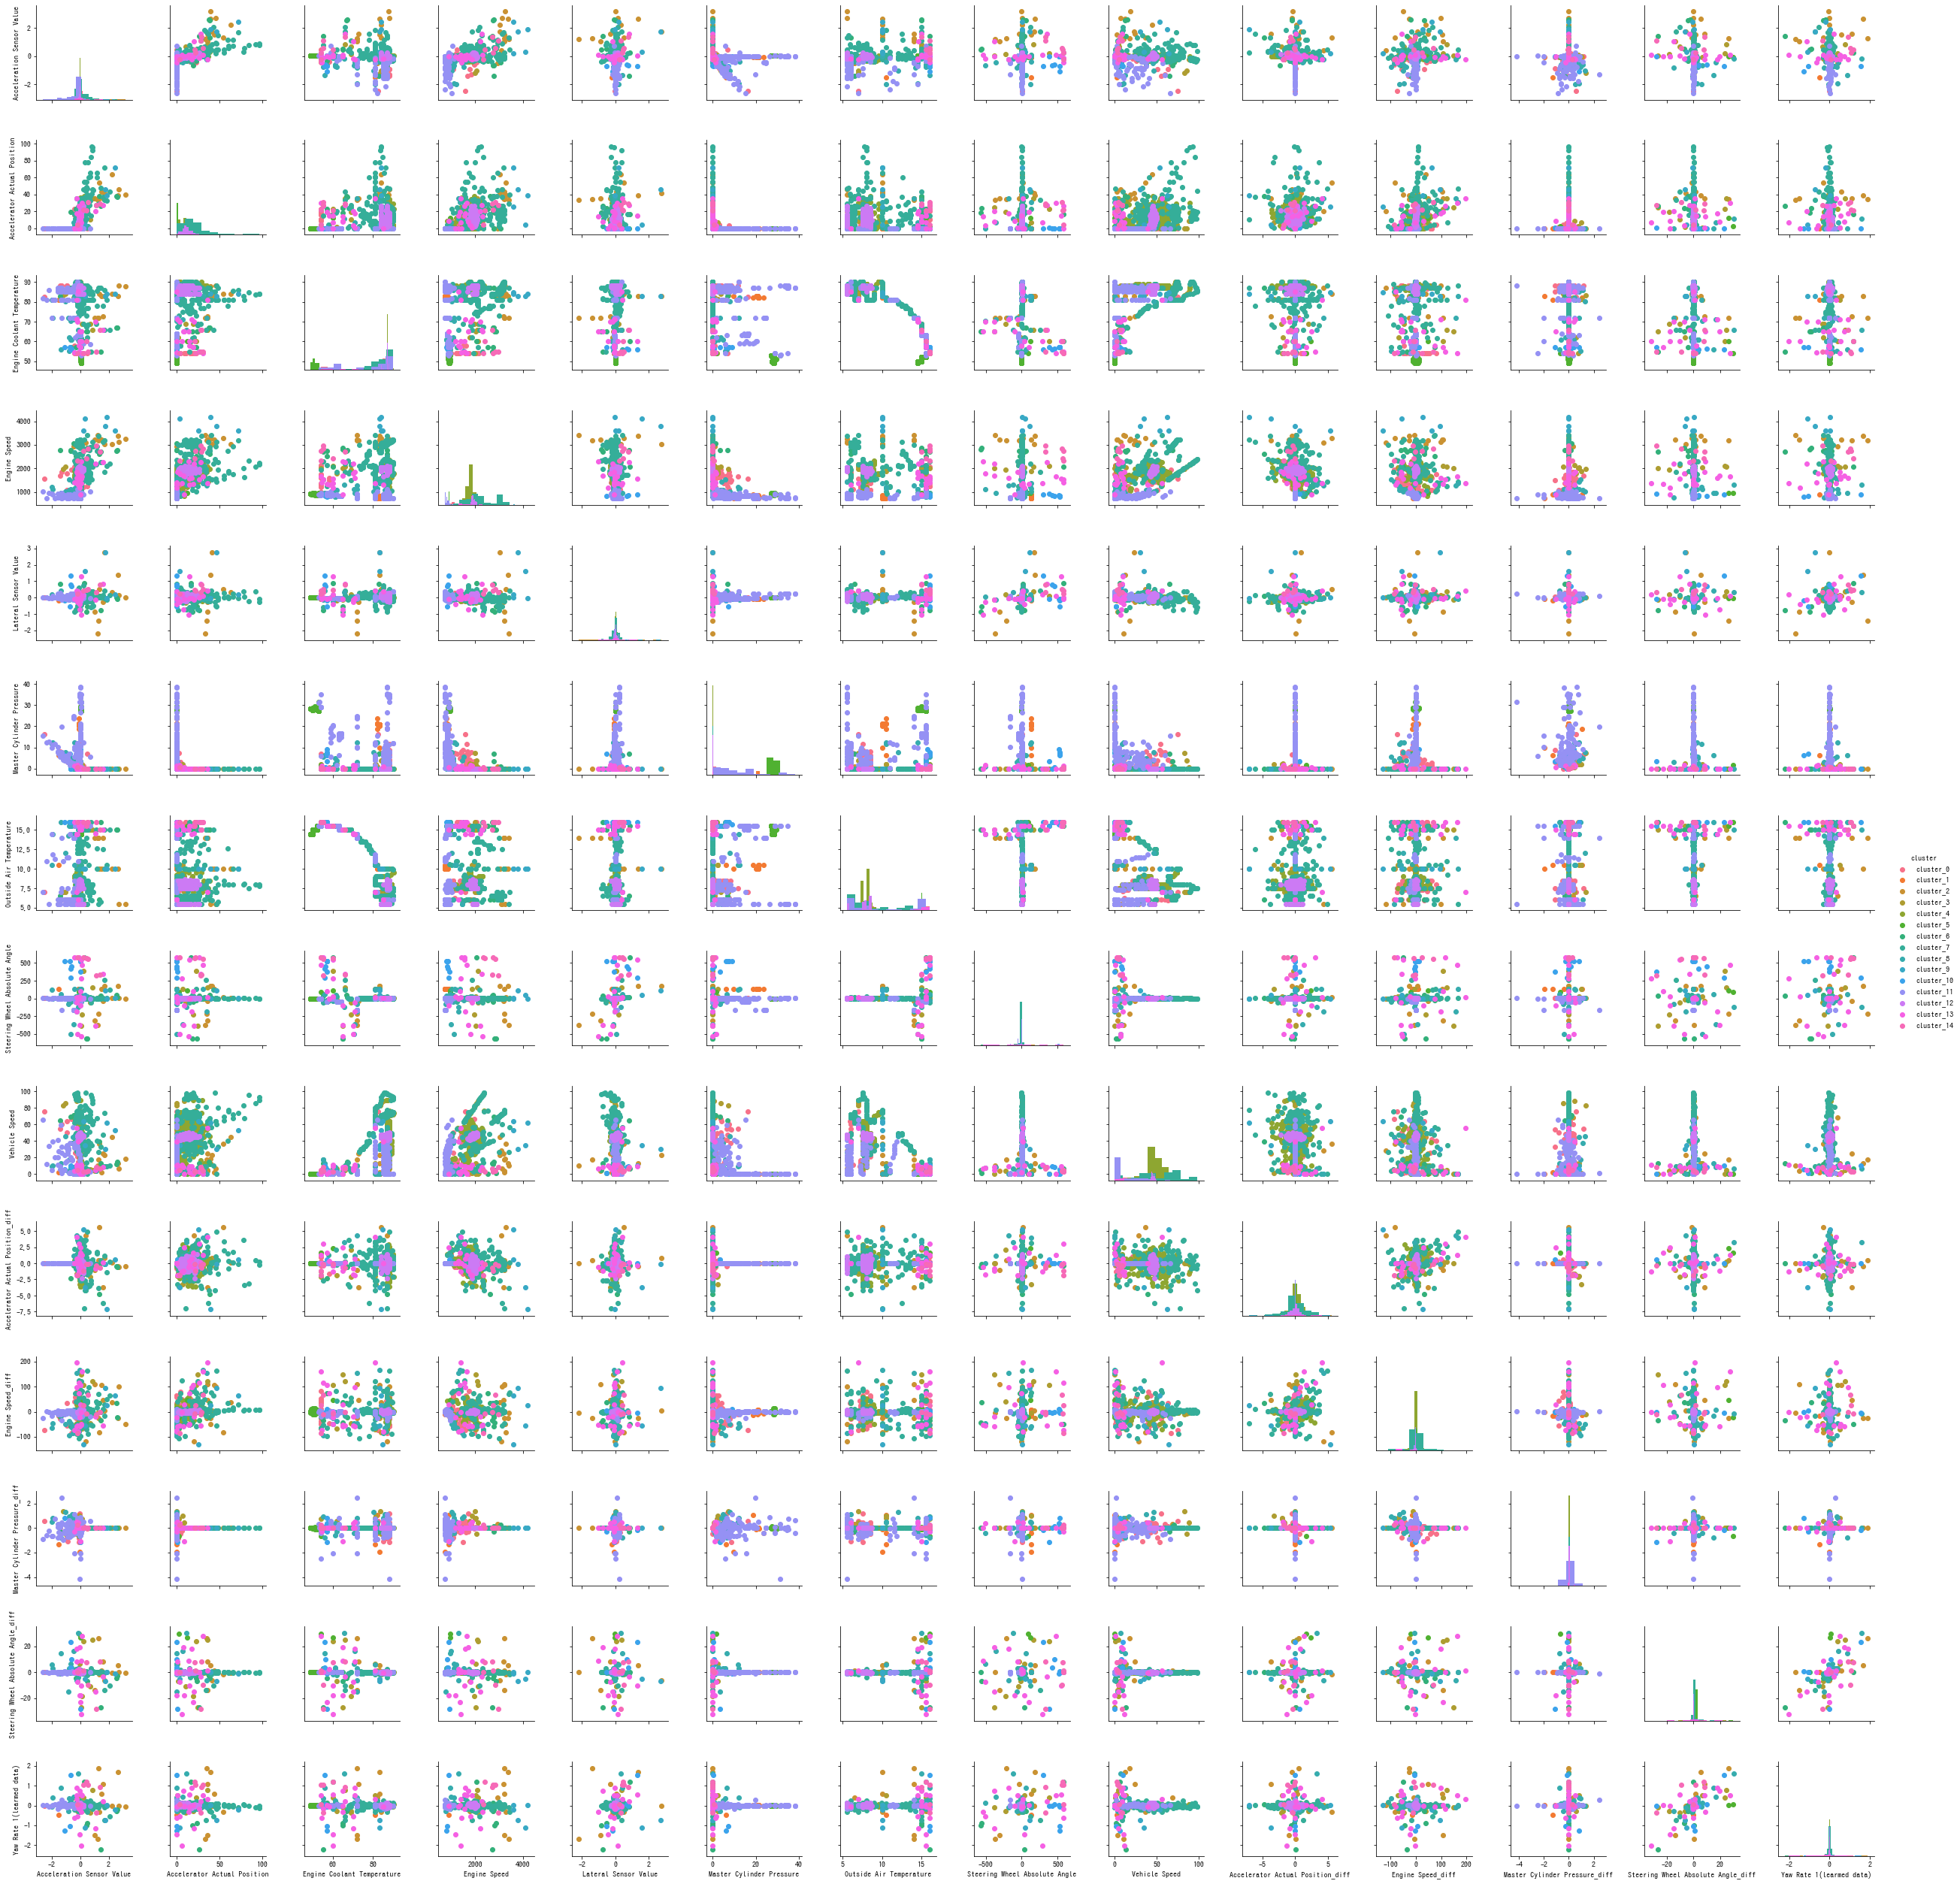

In [32]:
g = sns.PairGrid(df_all_menu_w_cluster, hue="cluster", 
                 hue_order=[f"cluster_{x}" for x in range(best_n_cluster)])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g = g.add_legend();
g.savefig("../reports/cluster_pairplot.png")

### 時系列プロットによる可視化

In [39]:
s_tmp.loc[res_cluster==1]

rounded_time2
00:05:29    81.0
00:05:33    82.0
00:05:34    82.0
00:05:35    82.0
00:05:36    82.0
00:05:37    82.0
00:05:38    82.0
00:05:39    82.0
00:05:40    82.4
00:05:41    83.0
00:05:42    83.0
00:05:43    83.0
00:05:44    83.0
00:05:45    83.0
00:05:46    83.0
00:05:47    83.0
00:05:48    83.0
00:05:49    83.0
00:05:50    83.0
00:05:51    83.0
00:05:52    83.0
00:05:53    83.0
Name: Engine Coolant Temperature, dtype: float64

In [45]:
17 * 0.7

11.899999999999999

In [46]:
7 * 14 * 0.7

68.6

In [48]:
df_all_manu.shape[1]

14

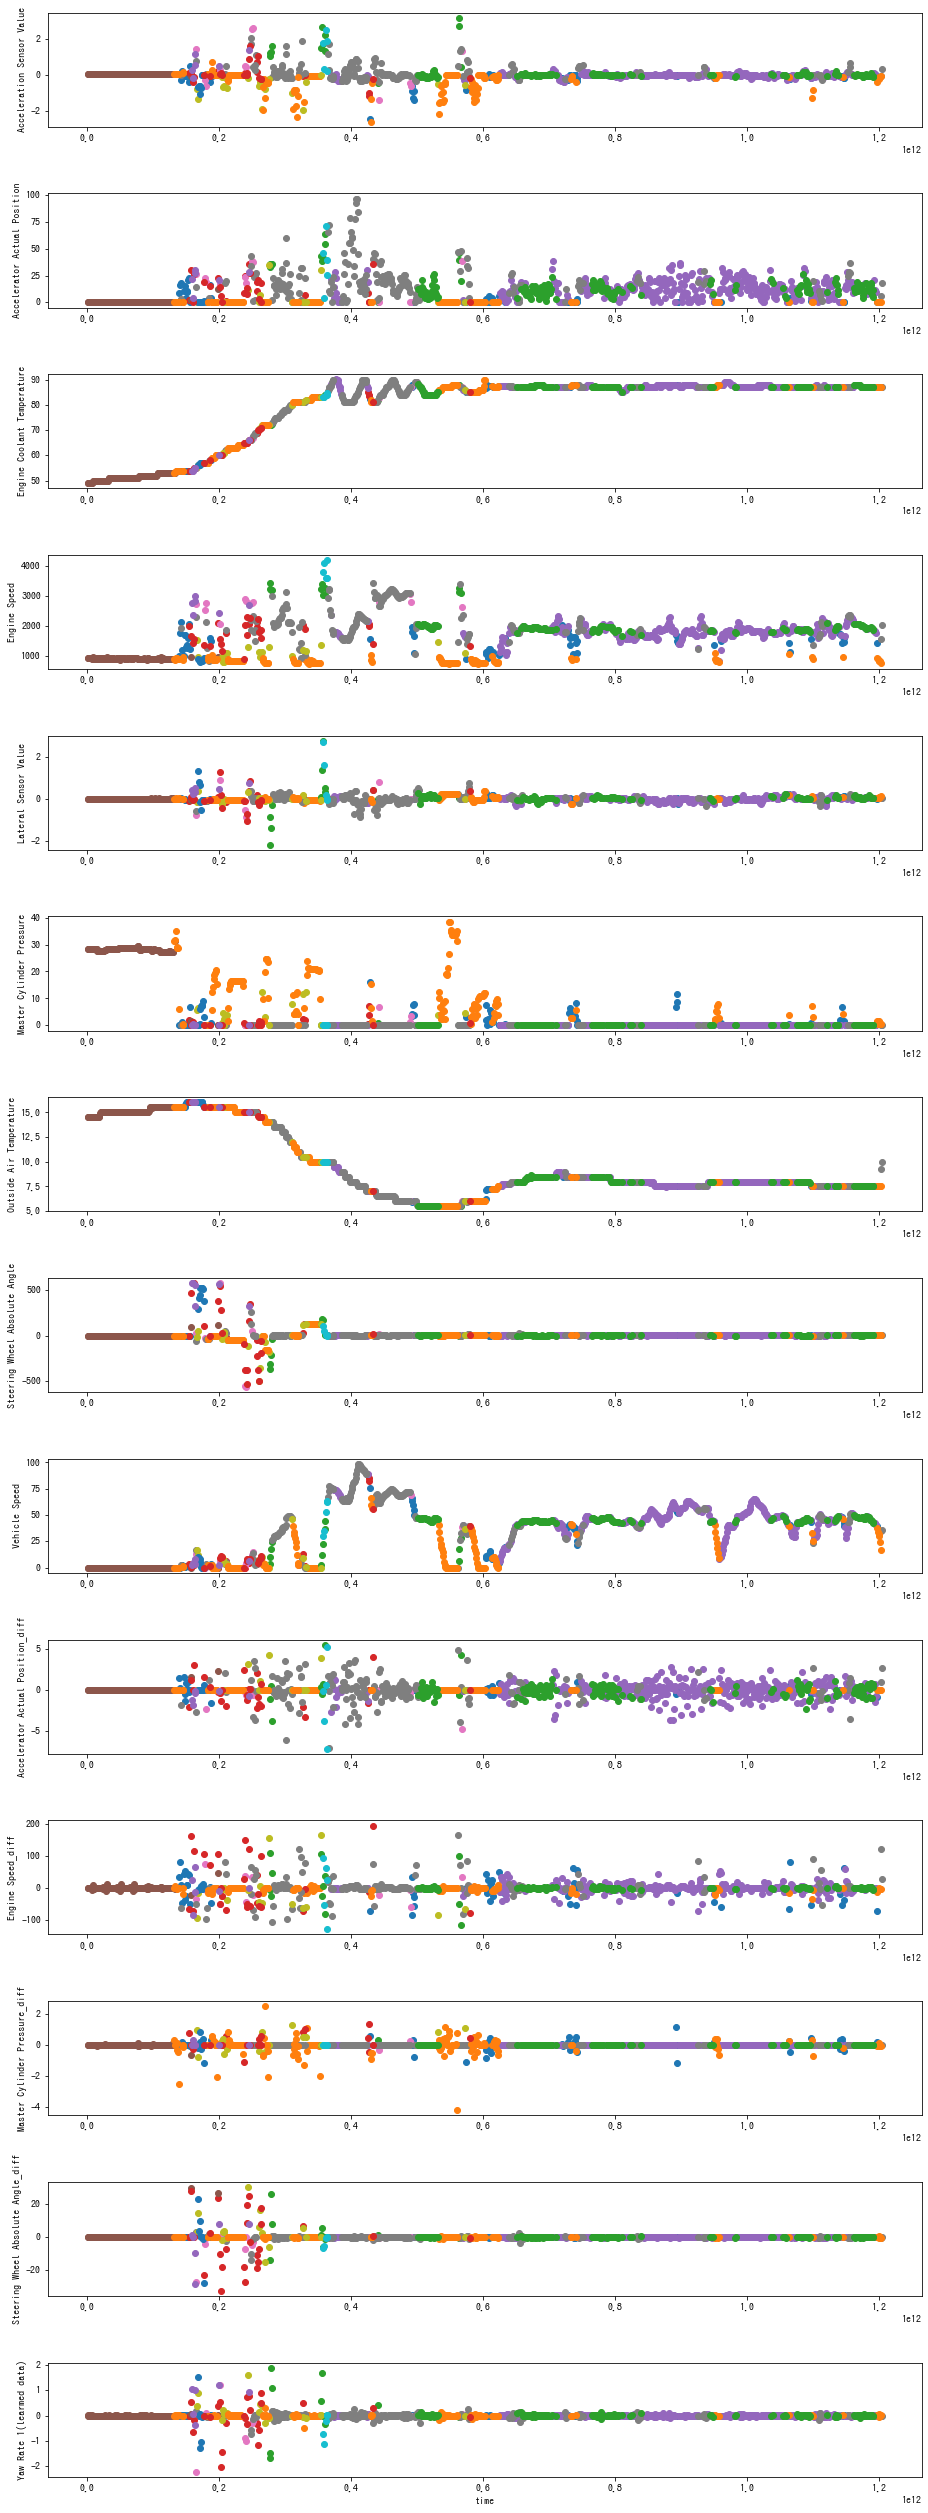

In [60]:
fig = plt.figure(figsize=(13,35))
for i, col in enumerate(df_all_manu.columns):
    ax = fig.add_subplot(14, 1, i+1)
    s_tmp = df_all_manu[col]
    for i in range(best_n_cluster):
        ax.plot(s_tmp[res_cluster==i], "o")
        ax.set(ylabel=col)
ax.set(xlabel="time")
plt.tight_layout()
plt.savefig("../reports/time_series_plot_w_cluster.png")

### 中央値による可視化

In [81]:
df_tmp_median = df_all_menu_w_cluster.groupby("cluster").agg("median").T

In [86]:
from scipy.stats import rankdata

In [85]:
for feature in df_all_menu_w_cluster.columns:
    s_feature = df_all_menu_w_cluster[feature]
    

AttributeError: module 'numpy' has no attribute 'stats'

In [83]:
df_all_menu_w_cluster

,Acceleration Sensor Value,Accelerator Actual Position,Engine Coolant Temperature,Engine Speed,Lateral Sensor Value,Master Cylinder Pressure,Outside Air Temperature,Steering Wheel Absolute Angle,Vehicle Speed,Accelerator Actual Position_diff,Engine Speed_diff,Master Cylinder Pressure_diff,Steering Wheel Absolute Angle_diff,Yaw Rate 1(learmed data),cluster
rounded_time2,,,,,,,,,,,,,,,
00:00:01,0.05000,0.000000,49.0,916.750,0.00625,28.255000,14.50,-7.700,0.000000,0.000000,0.100,0.000000,0.000,-5.000000e-04,cluster_5
00:00:02,0.06250,0.000000,49.0,921.100,0.00625,28.300000,14.50,-7.700,0.000000,0.000000,0.250,0.000000,0.000,3.500000e-03,cluster_5
00:00:03,0.06250,0.000000,49.0,921.825,0.01250,28.300000,14.50,-7.690,0.000000,0.000000,0.850,0.000000,0.000,-1.000000e-03,cluster_5
00:00:04,0.06250,0.000000,49.0,926.800,0.00625,28.300000,14.50,-7.700,0.000000,0.000000,-0.850,0.000000,0.000,-4.000000e-03,cluster_5
00:00:05,0.06250,0.000000,49.0,917.825,0.01250,28.300000,14.50,-7.700,0.000000,0.000000,-0.650,0.000000,0.000,3.500000e-03,cluster_5
00:00:06,0.06250,0.000000,49.0,908.900,0.00625,28.400000,14.50,-7.700,0.000000,0.000000,-0.525,0.010000,0.000,-1.500000e-03,cluster_5
00:00:07,0.06250,0.000000,49.0,907.300,0.00625,28.400000,14.50,-7.700,0.000000,0.000000,0.825,0.000000,0.000,8.500000e-03,cluster_5
00:00:08,0.05625,0.000000,49.0,909.650,0.00625,28.350000,14.50,-7.700,0.000000,0.000000,-4.900,0.000000,0.000,-6.500000e-03,cluster_5
00:00:09,0.06250,0.000000,49.3,897.150,0.00625,28.360000,14.50,-7.700,0.000000,0.000000,9.700,0.000000,0.000,1.000000e-03,cluster_5


In [82]:
df_tmp_median

cluster,cluster_0,cluster_1,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
Acceleration Sensor Value,-0.081250,-0.062500,-0.612500,-0.043750,-0.012500,-0.015625,0.512500,1.512500,0.018750,-0.006250,0.06250,0.359375,0.018750,-0.6250,1.743750
Accelerator Actual Position,0.000000,0.000000,0.000000,0.000000,11.235294,14.127451,24.656863,38.980392,7.686274,12.215686,0.00000,21.147059,17.725490,0.0000,39.254902
Engine Coolant Temperature,87.000000,83.000000,57.000000,85.000000,87.000000,65.000000,55.000000,83.000000,69.000000,87.000000,51.00000,65.950000,85.000000,71.0000,84.000000
Engine Speed,1467.937500,751.900000,838.550000,822.275000,1913.425000,1553.875000,2723.762500,3201.150000,2023.875000,1800.650000,906.21250,2764.537500,2157.050000,1082.5750,3790.450000
Lateral Sensor Value,0.012500,-0.062500,-0.062500,0.000000,0.050000,-0.056250,0.459375,0.031250,-0.006250,0.018750,0.00625,-0.040625,0.006250,-0.0250,0.206250
Master Cylinder Pressure,1.313437,20.810625,6.275000,10.784375,0.000000,0.000000,0.000000,0.000000,1.188359,0.000000,28.29000,0.000000,0.000000,3.8550,0.000000
Outside Air Temperature,7.875000,10.000000,16.000000,8.000000,8.000000,15.000000,16.000000,10.000000,15.000000,8.000000,15.00000,15.000000,8.000000,14.5000,10.000000
Steering Wheel Absolute Angle,3.095000,132.600000,521.745000,2.587500,2.910000,12.237500,563.530000,2.185000,4.177500,3.470000,-7.69000,3.677500,3.000000,-6.1550,5.225000
Vehicle Speed,35.062500,0.000000,1.083594,0.332031,45.211719,7.595313,4.498438,18.276563,4.936719,47.047656,0.00000,12.380859,56.275781,7.8875,53.031250
Accelerator Actual Position_diff,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.529412,0.058823,-0.921569,0.000000,0.00000,-0.333333,0.000000,0.0000,-0.098039


In [77]:
df_tmp = df_tmp.unstack().reset_index().rename(columns={"level_1":"feature", 0:"val"})

In [ ]:
for i in [f"cluster_{i}" for i in range(best_n_cluster)]:
    vals = df_tmp.loc[df_tmp.cluster==i, "val"]
    

In [78]:
df_tmp.head()

,cluster,feature,val
0,cluster_0,Acceleration Sensor Value,-0.08125
1,cluster_0,Accelerator Actual Position,0.00000
2,cluster_0,Engine Coolant Temperature,87.00000
3,cluster_0,Engine Speed,1467.93750
4,cluster_0,Lateral Sensor Value,0.01250


In [68]:
df_tmp.plot.scatter(x=)

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

In [65]:
df_tmp.head()

cluster,index,cluster_0,cluster_1,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,Acceleration Sensor Value,-0.08125,-0.0625,-0.6125,-0.04375,-0.012500,-0.015625,0.512500,1.512500,0.018750,-0.006250,0.06250,0.359375,0.01875,-0.625,1.743750
1,Accelerator Actual Position,0.00000,0.0000,0.0000,0.00000,11.235294,14.127451,24.656863,38.980392,7.686274,12.215686,0.00000,21.147059,17.72549,0.000,39.254902
2,Engine Coolant Temperature,87.00000,83.0000,57.0000,85.00000,87.000000,65.000000,55.000000,83.000000,69.000000,87.000000,51.00000,65.950000,85.00000,71.000,84.000000
3,Engine Speed,1467.93750,751.9000,838.5500,822.27500,1913.425000,1553.875000,2723.762500,3201.150000,2023.875000,1800.650000,906.21250,2764.537500,2157.05000,1082.575,3790.450000
4,Lateral Sensor Value,0.01250,-0.0625,-0.0625,0.00000,0.050000,-0.056250,0.459375,0.031250,-0.006250,0.018750,0.00625,-0.040625,0.00625,-0.025,0.206250


In [ ]:
df_tmp.drop()scatter()

In [ ]:
fig = plt.figure(figsize=(13,35))
for i, col in enumerate(df_all_manu.columns):
    ax = fig.add_subplot(14, 1, i+1)
    s_tmp = df_all_manu[col]
    for i in range(best_n_cluster):
        ax.plot(s_tmp[res_cluster==i], "o")
        ax.set(ylabel=col)
ax.set(xlabel="time")
plt.tight_layout()
plt.savefig("../reports/time_series_plot_w_cluster.png")